**Description of the Dataset**

The dataset you will use in this homework is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different services. The 60 input variables are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders.

You can learn more about this dataset on the UCI Machine Learning repository (https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks).

- All the variables are continuous and generally in the range of 0 to 1.
- The output variable (which is label or target variable) is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.
- It is a binary classification dataset. You would prefer a numeric label over a string label. You can do such conversion with LabelEncoder in scikit-learn. The LabelEncoder is to map each label to an integer. In this case, there are only two labels and they will become 0 and 1.

### Import Libreries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import copy
import tqdm

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve

### Load the Dataset

In [ ]:
# Upload data file Google Colab
from google.colab import files
uploaded = files.upload()
#Read the data
data = pd.read_csv("sonar.csv", header=None)
X = data.iloc[:, 0:60]  # input features
y = data.iloc[:, 60]    # target variable

Saving sonar.csv to sonar.csv


### Pre-process data and convert to torch tensors: 10 points

1- Label Encode the target variable

In [ ]:
# I encode the target variable label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

2- Convert the features and target numpy arrays into tensors and print their shapes

In [ ]:
# I convert the data to tensor and print their shapes
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.float32)
print("X shape:", X_tensor.shape)
print("y shape:", y_tensor.shape)

X shape: torch.Size([208, 60])
y shape: torch.Size([208])


### Creating Neural Network Models for Binary Classification

As you have seen in the lecture, the easiest neural network model is a 3-layer model that has only one hidden layer. A deep learning model is usually referring to those with more than one hidden layer. All neural network models have parameters called weights. The more parameters a model has, heuristically we believe that it is more powerful.

Should you use a model with fewer layers but more parameters on each layer, or a model with more layers but less parameters each?

Because it is a binary classification problem, the output have to be a vector of length 1. Then you also want the output to be between 0 and 1 so you can consider that as probability or the model’s confidence of prediction that the input corresponds to the “positive” class.

#### Shallow Model

3- Create a shallow model with only one hidden layer but with more neurons than number of input features, aka a wider model

In [ ]:
# Defining a shallow model with a hidden layer larger than the input
class ShallowNet(nn.Module):
    def __init__(self):
        super(ShallowNet, self).__init__()
        self.fc1 = nn.Linear(60, 128)  #60 inputs - 128 hidden neurons
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)   # than 1 output, (binary classification.)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

model = ShallowNet()

#### Deep Model

4- A model with more layer is called a deeper model. This time, you should create a neurol network model with with two hidden layers

In [ ]:
# Defining a deep model with 2 hidden layers and
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.fc1 = nn.Linear(60, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc4(x))
        return x

deep_model = DeepNet()

5- Compare model sizes - number of parameters

In [ ]:
# We compare the total number of parameters of ShallowNet and DeepNet models
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

shallow_params = count_parameters(model)
deep_params = count_parameters(deep_model)

print("Shallow model parameter count:", shallow_params)
print("Deep model parameter count:", deep_params)

Shallow model parameter count: 7937
Deep model parameter count: 18177


### Model Training

Build a function which you call to train your models:
- Embed the training process within a function,
- Monitor accuracy and evaluate accuracy at end of each epoch,
- For the model which gives the best accuracy, restore model and return best accuracy

In [ ]:
# Function that trains the model, tracks and restores best accuracy
def train_model(model, X, y, epochs=50, lr=0.001):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(X).squeeze()
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # Accuracy calculations
        preds = (outputs >= 0.5).float()
        acc = (preds == y).float().mean().item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

        # Check which model is better
        if acc > best_acc:
            best_acc = acc
            best_model = copy.deepcopy(model.state_dict())

    # Load the best model
    model.load_state_dict(best_model)
    return best_acc

### Comparing Models with Cross-Validation
Should you use a shallow model or a deep model? One way to tell is to use cross-validation to compare them. Apply k-fold cross validation to compare the models you have created

The technique that you will use here is called k-fold cross validation. It is to split a larger dataset into portions and take one portion as the test set while the portions are combined as the training set. There are different such combinations. Therefore you can repeat the experiment for times and take the average result.

- Build a 5-fold cross validation test, and apply this test to both models you have created: shallow and deep models.
- Evaluate the results by taking the mean of the accuracy and standar deviation for each models

You should compare the two model designs: By running k-fold cross validation on each and compare the accuracy:

In [ ]:
# Compare the 2 models using 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

shallow_accuracies = []
deep_accuracies = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_tensor, y_tensor)):
    print(f"\nFold {fold+1}")

    X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
    y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

    # Train shalow model
    shallow = ShallowNet()
    shallow_acc = train_model(shallow, X_train, y_train, epochs=50)
    shallow_accuracies.append(shallow_acc)

    # Train Deep model
    deep = DeepNet()
    deep_acc = train_model(deep, X_train, y_train, epochs=50)
    deep_accuracies.append(deep_acc)

# Calculating the mean and standard deviation
shallow_mean = np.mean(shallow_accuracies)
shallow_std = np.std(shallow_accuracies)

deep_mean = np.mean(deep_accuracies)
deep_std = np.std(deep_accuracies)

print("\nShallow Model - Mean Accuracy:", round(shallow_mean, 4), "Std:", round(shallow_std, 4))
print("Deep Model    - Mean Accuracy:", round(deep_mean, 4), "Std:", round(deep_std, 4))


Fold 1
Epoch 1/50, Loss: 0.6886, Accuracy: 0.5422
Epoch 2/50, Loss: 0.6856, Accuracy: 0.5361
Epoch 3/50, Loss: 0.6829, Accuracy: 0.5361
Epoch 4/50, Loss: 0.6803, Accuracy: 0.5361
Epoch 5/50, Loss: 0.6778, Accuracy: 0.5422
Epoch 6/50, Loss: 0.6754, Accuracy: 0.5422
Epoch 7/50, Loss: 0.6731, Accuracy: 0.5422
Epoch 8/50, Loss: 0.6707, Accuracy: 0.5482
Epoch 9/50, Loss: 0.6683, Accuracy: 0.5663
Epoch 10/50, Loss: 0.6658, Accuracy: 0.5663
Epoch 11/50, Loss: 0.6634, Accuracy: 0.5723
Epoch 12/50, Loss: 0.6609, Accuracy: 0.5843
Epoch 13/50, Loss: 0.6584, Accuracy: 0.6024
Epoch 14/50, Loss: 0.6558, Accuracy: 0.6325
Epoch 15/50, Loss: 0.6532, Accuracy: 0.6566
Epoch 16/50, Loss: 0.6505, Accuracy: 0.6807
Epoch 17/50, Loss: 0.6478, Accuracy: 0.6807
Epoch 18/50, Loss: 0.6450, Accuracy: 0.6867
Epoch 19/50, Loss: 0.6422, Accuracy: 0.6867
Epoch 20/50, Loss: 0.6394, Accuracy: 0.6867
Epoch 21/50, Loss: 0.6364, Accuracy: 0.6928
Epoch 22/50, Loss: 0.6335, Accuracy: 0.6928
Epoch 23/50, Loss: 0.6304, Accura

## Re-train the Final Model and Evaluate

Pick the best model and retrain it for the final model generation

In [ ]:
# I choose the best model according to the 5-fold cross-validation results (DeepNet)
best_model_name = "DeepNet" if deep_mean > shallow_mean else "ShallowNet"
print(f"{best_model_name} selected as final model based on cross-validation results.")

# Starting the best model as the final model
final_model = DeepNet() if best_model_name == "DeepNet" else ShallowNet()

# Re-traning final model with entire dataset
final_accuracy = train_model(final_model, X_tensor, y_tensor, epochs=50)
print("Final model accuracy on full data:", round(final_accuracy, 4))

DeepNet selected as final model based on cross-validation results.
Epoch 1/50, Loss: 0.6937, Accuracy: 0.4904
Epoch 2/50, Loss: 0.6927, Accuracy: 0.5000
Epoch 3/50, Loss: 0.6903, Accuracy: 0.5433
Epoch 4/50, Loss: 0.6893, Accuracy: 0.5240
Epoch 5/50, Loss: 0.6920, Accuracy: 0.5577
Epoch 6/50, Loss: 0.6882, Accuracy: 0.5481
Epoch 7/50, Loss: 0.6864, Accuracy: 0.5529
Epoch 8/50, Loss: 0.6861, Accuracy: 0.5769
Epoch 9/50, Loss: 0.6865, Accuracy: 0.5385
Epoch 10/50, Loss: 0.6860, Accuracy: 0.5385
Epoch 11/50, Loss: 0.6830, Accuracy: 0.5433
Epoch 12/50, Loss: 0.6834, Accuracy: 0.5529
Epoch 13/50, Loss: 0.6817, Accuracy: 0.5481
Epoch 14/50, Loss: 0.6815, Accuracy: 0.5433
Epoch 15/50, Loss: 0.6808, Accuracy: 0.5288
Epoch 16/50, Loss: 0.6758, Accuracy: 0.5529
Epoch 17/50, Loss: 0.6737, Accuracy: 0.5577
Epoch 18/50, Loss: 0.6709, Accuracy: 0.5529
Epoch 19/50, Loss: 0.6680, Accuracy: 0.5913
Epoch 20/50, Loss: 0.6706, Accuracy: 0.5673
Epoch 21/50, Loss: 0.6696, Accuracy: 0.5913
Epoch 22/50, Loss:

Plot the receiver operating characteristic curve (ROC) for model performance visualization

<ipython-input-16-874ff5c69baa>:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {np.trapz(tpr, fpr):.4f})")


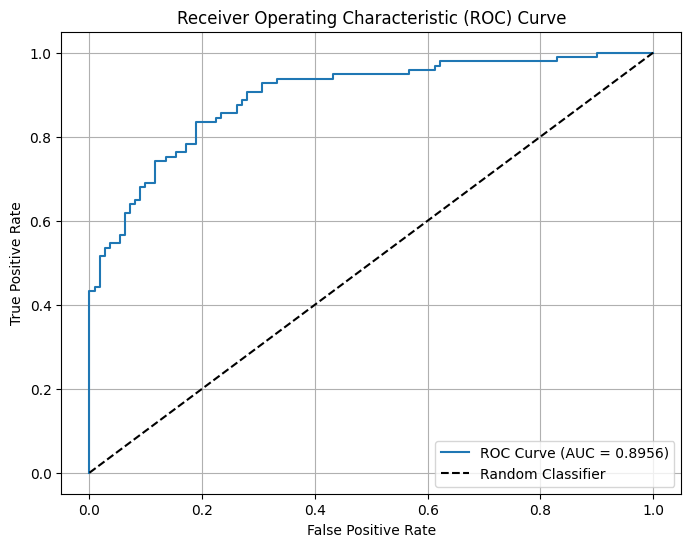

In [ ]:
# Evaluate the model for ROC curve(plot)
final_model.eval()
with torch.no_grad():
    y_scores = final_model(X_tensor).squeeze().numpy()

# Using true labels and predicted probabilities for the ROC curve
fpr, tpr, _ = roc_curve(y_tensor.numpy(), y_scores)

# Draw ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {np.trapz(tpr, fpr):.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()